# JEDI 2018 - Atelier 3B
> Pré-requis :
- quelques (restes de) notions d'algèbre linéaire ;
- quelques (restes de) notions de géométrie dans l'espace ;
- savoir écrire et lire des fonctions en Python.

> Objectifs :
- découvrir la programmation orientée objet ;
- lire et enrichir le code source d'une bibliothèque écrite par d'autres ;
- découvrir la synthèse d'images par l'algorithme de lancer de rayon ;
- découvrir la géométrie de construction de solides ;
- manipuler des arbres comme structure de données représentant des combinaisons booléennes d'objets solides simples ;
- écrire quelques classes et méthodes et observer le découpage d'un gros projet en plusieurs classes simples grâce au principe d'encapsulation ;
- se confronter aux problèmes de précision et de stabilité du calcul en nombres flottants.

> Extensions possibles (non traitées ici) :
- améliorer la mise en œuvre du lancer de rayon en évitant les calculs d'intersection inutiles par l'emploi de structures de données appropriées pour décrire la scène ;
- enrichir le modèle en ajoutant la gestion de la réfraction ;
- améliorer le réalisme du rendu en gérant les ombres douces et la profondeur de champ ;
- enrichir les matériaux en ajoutant la gestion des textures.




# Initiation à la programmation orientée objet en Python 3

L'objectif de cet atelier de travaux pratique est de vous initier à la programmation orientée objet en Python en mettant en pratique les éléments du langage présentés lors de l'atelier 3A. Pour cela, nous allons étudier et enrichir le code source d'un projet libre de moteur de lancer de rayon appelé *pyRT* (prononcer *pirate* avec un accent anglais)
[![pyRT](img/logo.png)](https://github.com/martinchristen/pyRT)

Pour paraphraser ses auteurs :

> PyRT est un générateur d'images/moteur de lancer de rayon pour Python 3.5. Ce projet est développé avec les objectifs suivants :
* ajouter les graphismes 2D aux carnets jupyter
* ajouter le lancer de rayon aux carnets jupyter
* enseigner le lancer de rayon
* (...)
>
> pyRT est en cours de développement. Tout est encore en version (pré-)alpha !
>
> pyRT **n'a aucune autre dépendance**, mais il est recommandé d'installer les modules suivants: pillow, numpy, jupyter.

## 1. À la découverte de pyRT

Le [code source](/tree/pyrt/) de la dernière version de *pyRT* est fourni avec l'énoncé. Il est constitué d'environ 3000 lignes de Python orientée objet. Il n'est pas question de tout lire mais plutôt de s'y référer lorsque le texte vous y invite. Une partie non négligeable de l'atelier consiste à s'aproprier le fonctionnement de *pyRT*.

### 1.1 Des vecteurs, des matrices et des images

Le module `pyrt.math` et ses sous-modules, définis dans le répertoire [pyrt/math](/tree/pyrt/math/), proposent toute sorte de classes et de fonctions pour manipuler des vecteurs de 2 à 4 nombres (`Vec2`, `Vec3`, `Vec4`) pour représenter des points et des vecteurs de l'espace et des matrices 4x4 (`Mat4`) pour représenter les transformations affines.

Prenez le temps de parcourir la définition de `Vec3` dans [pyrt/math/vec3.py](/edit/pyrt/math/vec3.py) et de comprendre comment celle-ci est utilisée dans [pyrt/math/vecops.py](/edit/pyrt/math/vecops.py) pour définir des fonctions comme `dot3`, `normalize3`, `min3` ou encore `reflect3`.

Voici à titre d'exemple une fonction qui teste si un point $P$ de l'espace 3D appartient au plan orthogonal au vecteur $\overrightarrow{V}$ et qui passe par le point $O$. Cette fonction se contente de tester si 
$(P-O)\cdot\overrightarrow{V} = 0$. Pour le test à zéro, il convient de prendre en compte les problèmes d'arrondis. La bibliothèque `pyrt.math` fournit la constante `G_EPSILON`.

Le module `pyrt.utils.pretty` défini dans [pyrt/utils/pretty.py](/edit/pyrt/utils/pretty.py) permet un affichage plus agréable des vecteurs est des matrices.

In [1]:
from math import fabs
from pyrt.math import Vec3, dot3, G_EPSILON
from pyrt.utils.pretty import *

def isZero(x):
    return fabs(x) < G_EPSILON

def on_plane(P, O, V):
    """teste si le point P appartient au plan
       orthogonal à V et qui passe par O."""
    return isZero(dot3(P-O, V))

O = Vec3(0, 0, 1)
V = Vec3(1, 1, 1)

s = "Test d'apartenance au plan passant par $O=%s$ orthogonal à $\overrightarrow{V}=%s$ :\n\n> " % (tolatex(O),tolatex(V))
l=[Vec3(0,0,0),Vec3(1,0,0),Vec3(0,1,0),Vec3(0,0,1),Vec3(3,-3,1),Vec3(3,-3,2),Vec3(2,-3,2)]
show(s + tomd([(P, on_plane(P, O, V)) for P in l]))

Test d'apartenance au plan passant par $O=\begin{pmatrix}0.0\\0.0\\1.0\end{pmatrix}$ orthogonal à $\overrightarrow{V}=\begin{pmatrix}1.0\\1.0\\1.0\end{pmatrix}$ :

> $\begin{pmatrix}0.0\\0.0\\0.0\end{pmatrix}$ False, $\begin{pmatrix}1.0\\0.0\\0.0\end{pmatrix}$ True, $\begin{pmatrix}0.0\\1.0\\0.0\end{pmatrix}$ True, $\begin{pmatrix}0.0\\0.0\\1.0\end{pmatrix}$ True, $\begin{pmatrix}3.0\\-3.0\\1.0\end{pmatrix}$ True, $\begin{pmatrix}3.0\\-3.0\\2.0\end{pmatrix}$ False, $\begin{pmatrix}2.0\\-3.0\\2.0\end{pmatrix}$ True

### 1.2 Des images

Le moteur de lancer de rayon synthétise une image à partir d'une scène tridimensionnelle. La classe `RGBImage` définie dans [pyrt/renderer/rgbimage.py](/edit/pyrt/renderer/rgbimage.py) permet de créer des images 2D d'une taille donnée, de dessiner dessus (points, lignes, cercles, rectangles) et d'afficher ces images dans jupyter et/ou de les sauvegarder dans un fichier.

Voici quelques exemples d'utilisation de cette classe.

In [2]:
from pyrt.renderer import RGBImage
from pyrt.math import Vec2, Vec3
import random


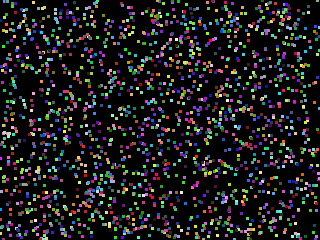

In [3]:
width,height = 320,240
image = RGBImage(width, height)

for i in range(2000):
    point = Vec2(random.randint(0, width-1), random.randint(0, height-1))
    color = Vec3(random.uniform(0, 1), random.uniform(0, 1), random.uniform(0, 1))
    image.drawPoint(point, color, 3)

image.display()


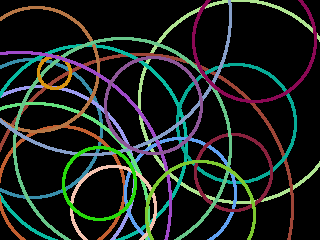

In [4]:
image = RGBImage(width, height)

for i in range(20):
    center = Vec2(random.randint(0, width-1), random.randint(0, height-1))
    radius = random.randint(3, width//2)
    color = Vec3(random.uniform(0, 1), random.uniform(0, 1), random.uniform(0, 1))
    image.drawCircle(center, radius, color, 3)
    
image.display()


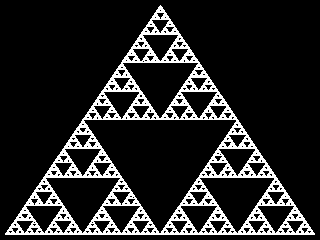

In [5]:
image = RGBImage(width, height)

A = Vec2(5,5)
B = Vec2(width-6, 5)
C = Vec2(width/2, height-6)
P = A
for i in range(10*width*height):
    P=(P + random.choice([A, B, C]))/2
    image.drawPoint(Vec2(round(P.x),round(P.y)), Vec3(1,1,1), 1)
    
image.display()

### 1.3 Des scènes 3D et du lancer de rayon

L'algorithme du lancer de rayon, que l'on peut attribuer à Appel 1968 et Whitted 1979, repose sur le principe décrit sur la figure suivante :

<img style="display: block; width: 70%; margin-left: auto; margin-right: auto" src="img/rtdiag.png">
<div style="text-align: center">*diagramme de principe du lancer de rayon (CC-BY-SA Henrik for [CommonsWiki](https://en.wikipedia.org/wiki/File:Ray_trace_diagram.svg))*</div>

Une scène 3D est modélisée par un certain nombre d'objets positionnés dans l'espace (ici une sphère), un certain nombre de sources de lumière et d'un observateur représenté par une caméra qui enregistre l'image de la scène.

L'algorithme reconstitue le trajet inverse de la lumière depuis l'œil de l'observateur, à travers chacun des pixels de l'image, vers les sources de lumière. Pour déterminer la couleur d'un pixel, on suit le rayon de l'œil de l'observateur, à travers le centre du pixel, jusqu'au premier objet de la scène intersecté. Puis on détermine la couleur de cet objet en ce point à partir du matériau utilisé et en déterminant quelles sources lumineuses sont visibles de ce point. Enfin, si le matériau est réfléchissant, on lance récursivement des rayons depuis le point pour déterminer la couleur de ce qui s'y reflète.

Dans *pyRT* :
* la classe `Scene` de [pyrt/scene/scene.py](/edit/pyrt/scene/scene.py) décrit la scène ;
* la classe `PointLight` de [pyrt/light/pointlight.py](/edit/pyrt/light/pointlight.py) décrit l'unique type de source de lumière ;
* la classe `Camera` de [pyrt/camera/camera.py](/edit/pyrt/camera/camera.py) décrit une caméra abstraite ;
* la classe `Shape` de [pyrt/geometry/shape.py](/edit/pyrt/geometry/shape.py) décrit les objets composant la scène (en pratique pour l'instant seules les méthodes `hit` et `hitShadow` sont utilisées) ;
* la classe `PhongMaterial` de [pyrt/material/phongmaterial.py](/edit/pyrt/material/phongmaterial.py) décrit le modèle de matériaux de Phong qui permet de connaître la couleur d'un point d'un objet en fonction de sa couleur, de l'angle d'incidence du rayon par rapport à la normale à la surface en ce point et des angles de réflexion des différentes sources de lumière ;
* la classe `SimpleRT` de [pyrt/renderer/simplert.py](/edit/pyrt/renderer/simplert.py) propose une première mise en œuvre de l'algorithme de lancer de rayon.

La version actuelle de *pyRT* ne propose que deux types d'objets pour décrire une scène :
* la classe `Sphere` de [pyrt/geometry/sphere.py](/edit/pyrt/geometry/sphere.py) décrit une sphère de centre, rayon et matériau donnés ;
* la classe `Triangle` de [pyrt/geometry/triangle.py](/edit/pyrt/geometry/triangle.py) décrit un triangle, dont chaque sommet de classe `Vertex` est donné et porte sa propre couleur, son propre matériau et son propre vecteur normal.

Voici un premier exemple complet d'utilisation de ces classes pour définir une scène et la dessiner à l'aide de `SimpleRT` :

# Creating Renderer: Simple Raytracer
# Shadow Enabled
# RENDER STATISTICS###############################
TIME FOR RENDERING: 6.71076512336731s
NUMBER OF PRIMARY RAYS: 76800
NUMBER OF SECONDARY RAYS: 0
NUMBER OF SHADOW RAYS: 39096
RAYS/s: 17270.161877137194
##################################################



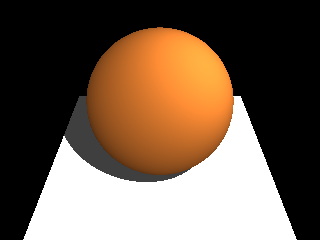

In [6]:
from pyrt.math import Vec3
from pyrt.scene import Scene
from pyrt.light import PointLight
from pyrt.geometry import Triangle, Sphere, Vertex
from pyrt.material import PhongMaterial
from pyrt.camera import PerspectiveCamera
from pyrt.renderer import SimpleRT
from pyrt.utils.colors import color

# Dimensions de l'image produite
width = 320
height = 240

# Crée une scène
scene = Scene()

# Ajoute un sol carré blanc
A = Vertex(position=(-5, -5, 0))
B = Vertex(position=( 5, -5, 0))
C = Vertex(position=( 5,  5, 0))
D = Vertex(position=(-5,  5, 0))

scene.add(Triangle(A,B,C, material=PhongMaterial(Vec3(1,1,1))))
scene.add(Triangle(A,C,D, material=PhongMaterial(Vec3(1,1,1))))

# Ajoute une sphère orange
scene.add(Sphere(Vec3(0,0,3), 3, PhongMaterial(Vec3(color["orange"]))))

# Crée une caméra perspective avec un angle de vue de 45°
camera = PerspectiveCamera(width, height, 45)

# Positionne la caméra en (0,-10,10) pointée sur (0,0,2) la verticale étant donnée par le vecteur z
camera.setView(Vec3(0.,-10.,10.), Vec3(0.,0.,2.), Vec3(0.,0.,1.))

# Ajoute la caméra à la scène
scene.setCamera(camera)

# Ajoute une source de lumière ponctuelle en (5,-10,15)
scene.addLight(PointLight(Vec3(5,-10,15)))

# Crée un lanceur de rayon avec ombrage
engine = SimpleRT(shadow=True)

# Dessine la scène
image = engine.render(scene)

# Affiche l'image 
image.display()

<div class="alert alert-info">
**Q1** Créez une scène utilisant plusieures sphères (par exemple un empilement de sphères). Attention toutefois à ne pas mettre trop d'objets dans la scène car le moteur de lancer de rayon n'est pas très véloce...
</div>

# RENDER STATISTICS###############################
TIME FOR RENDERING: 27.660160064697266s
NUMBER OF PRIMARY RAYS: 76800
NUMBER OF SECONDARY RAYS: 0
NUMBER OF SHADOW RAYS: 48975
RAYS/s: 4547.153729617312
##################################################



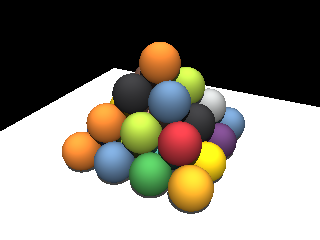

In [7]:
scene = Scene()

camera.setView(Vec3(3.,-6.,5.), Vec3(0.,0.,1.), Vec3(0.,0.,1.))
scene.setCamera(camera)
scene.addLight(PointLight(Vec3(5,-10,15)))

scene.add(Triangle(A,B,C, material=PhongMaterial(Vec3(1,1,1))))
scene.add(Triangle(A,C,D, material=PhongMaterial(Vec3(1,1,1))))

def randommat():
    """Une couleur aléatoire pour égayer votre scène"""
    return PhongMaterial(Vec3(random.choice(list(color.values()))))

# TODO : ajouter vos sphères ci-dessous



    
image = engine.render(scene)
image.display()

## 2. Ajouter des objets non bornés : des plans et des cylindres

Il est temps maintenant d'ouvrir le capot et de commencer à enrichir pyRT.

La classe `Shape` de [pyrt/geometry/shape.py](/edit/pyrt/geometry/shape.py) décrit les objets composant la scène. En pratique, pour être utilisé avec le moteur de lancer de rayon comme objet géométrique, un objet Python doit fournir les deux méthodes `hit` et `hitShadow` dont le comportement attendu est le suivant :
* `hitShadow(self, ray)` teste si le rayon `ray` intersecte l'objet (renvoie True ou False) ;
* `hit(self, ray, hitrecord)` teste si le rayon `ray` intersecte l'objet, avant l'instant `hitrecord.t` lorsque celui-ci est défini, et met à jour les informations de collision dans l'objet `hitrecord`.

Les classes `Ray` représentant les rayons et `HitRecord` représentant les points d'intersection avec un objet sont définis dans le module `pyrt.math.ray` à consulter dans [pyrt/math/ray.py](/edit/pyrt/math/ray.py).

Un rayon d'origine $C$ et de vecteur de direction $\overrightarrow{D}$ décrit la demi-droite paramétrée $P(t)=C+t\overrightarrow{D}$ pour $t>0$. Ce rayon est représenté par l'instance `r=Ray(C,D)` qui possède les attributs suivants :
* `r.start` : le point $C$ ;
* `r.direction` : le vecteur $\overrightarrow{D}$ ;
* `r.invdir` : le vecteur inverse multiplicatif de $\overrightarrow{D}$, *i.e.* $\begin{pmatrix}1/D_x\\1/D_y\\1/D_z\end{pmatrix}$.

Une instance de la classe `HitRecord` représente une intersection entre un rayon $P(t)$ et un objet $X$ de la scène. Ses principaux attributs sont :
* `hitrecord.t` : l'instant $t$ de collision entre le rayon et l'objet ;
* `hitrecord.obj` : l'objet $X$ rencontré par le rayon ;
* `hitrecord.point` : le point $P(t)$ où a lieu la collision ;
* `hitrecord.material` : le matériau au point de collision ;
* `hitrecord.normal` et `hitrecord.normal_g` : la normale à l'objet au point de collision.


Compléter le code ci-dessous pour ajouter des objets plans infinis et des objets cylindre infini d'axe $z$ et de rayon 1. Lorsque c'est nécessaire, on pourra utiliser le solveur d'équation du second degré décrit dans [pyrt/math/solver2.py](/edit/pyrt/math/solver2.py).


### 2.1 Plans infinis

La classe `Plane` représente un plan donné par un point $O$ et un vecteur orthogonal $\overrightarrow{V}$. Le constructeur `__init__` stocke ces deux valeurs dans des attributs après avoir normalisé le vecteur. Les méthodes `hit` et `hitShadow` testent la collision en cherchant l'instant $t$ tel que $(P(t)-O)\cdot\overrightarrow{V}=0$.

<div class="alert alert-info">
**Q2** Complétez le code ci-dessous et vérifiez que l'exemple donne bien le résultat attendu. La méthode `hittime` cherche l'instant de la collision et retourne ce temps $t$ ou `None` s'il n'y a pas collision.
</div>

In [8]:
from pyrt.geometry import Shape
from pyrt.math import normalize

class Plane(Shape):
    def __init__(self, point, vector, material = PhongMaterial()):
        """Défini un plan orthogonal à [vector] et qui passe par [point] de matériau [material]"""
        self.point = point
        self.vector = normalize(vector)
        self.material = material
    
    def hittime(self,ray):
        """Instant de collision entre [ray] et le plan ou None si non défini"""
        # TODO : tester la collision et retourner l'instant
       
    
    
        
    def hit(self, ray, hitrecord):
        t=self.hittime(ray)
        if t and t > 0:
            if hitrecord.t and hitrecord.t < t:
                return False
            else:
                hitrecord.t = t
                hitrecord.point = ray.start + t * ray.direction
                hitrecord.normal_g = self.vector
                hitrecord.normal = hitrecord.normal_g
                hitrecord.material = self.material
                hitrecord.color = Vec3(1,1,1)
                return True
        else:
            return False
        
    def hitShadow(self, ray):
        t=self.hittime(ray)
        return t and t > 0
        

Si le code ci-dessus est correct, la scène ci-dessous devrait faire apparaître un plan gris, une demi-sphère bleu et une sphère verte. La sphère rouge est cachée par le plan. En cas de difficultés, n'hésitez pas à ajouter une cellule et à faire des tests en appelant directement `hittime` pour un plan et un rayon connus.

# RENDER STATISTICS###############################
TIME FOR RENDERING: 7.129427909851074s
NUMBER OF PRIMARY RAYS: 76800
NUMBER OF SECONDARY RAYS: 0
NUMBER OF SHADOW RAYS: 66711
RAYS/s: 20129.385108404553
##################################################



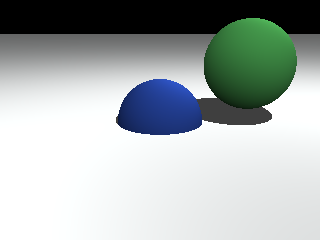

In [9]:
scene = Scene()

mat = [PhongMaterial(color=Vec3(color[i])) for i in ["neutral 8", "red", "blue", "green"]]

scene.add(Plane(Vec3(0,0,0), Vec3(0,0,1), mat[0]))

for i in range(3):
    scene.add(Sphere(Vec3(3*i-3,0,2*(i-1)), 1.5, mat[i+1]))

camera = PerspectiveCamera(width, height, 45)
camera.setView(Vec3(0.,-10.,3.), Vec3(0.,0.,0.), Vec3(0.,0.,1.))
scene.setCamera(camera)

scene.addLight(PointLight(Vec3(5,-10,15)))
image = engine.render(scene)
image.display()

### 2.2 Cylindres infinis

La classe `Cylinder` représente un cylindre infini d'axe $z$, donné par un point $O$ et un rayon $r$ et dont l'équation implicite de la surface est donnée par la formule :
$$(x-O_x)^2 + (y-O_y)^2 = r^2$$

Pour résoudre cette équation implicite appliquée au point paramétré $P(t)$ d'un rayon, on utilisera la fonction `solve2` définie dans [pyrt/math/solver2.py](/edit/pyrt/math/solver2.py). 

<div class="alert alert-info">
**Q3**
Écrire le code de la classe `Cylinder` en s'inspirant de ce qui a été fait pour `Plane` et vérifier que l'exemple donne le résultat attendu.
</div>

In [10]:
from pyrt.math.solver2 import solve2

class Cylinder:
    # TODO : tout est à écrire !
    def __init__(self, point, radius, material = PhongMaterial()):
        """Défini un cylindre d'axe z passant par [point], de rayon [radius] et de matériau [material]"""
    
    
    
    
    
    

Si le code ci-dessus est correct, la scène ci-dessous devrait faire apparaître un plan gris et trois cylindres rouge, bleu et vert. En cas de difficultés, n'hésitez pas à ajouter une cellule et à faire des tests en appelant directement `hittime` pour un plan et un rayon connus.

# RENDER STATISTICS###############################
TIME FOR RENDERING: 7.8851001262664795s
NUMBER OF PRIMARY RAYS: 76800
NUMBER OF SECONDARY RAYS: 0
NUMBER OF SHADOW RAYS: 59860
RAYS/s: 17331.42227893398
##################################################



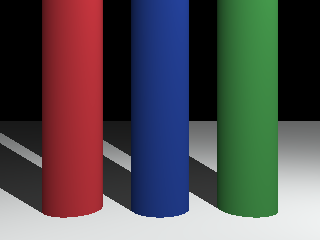

In [11]:
scene = Scene()

mat = [PhongMaterial(color=Vec3(color[i])) for i in ["neutral 8", "red", "blue", "green"]]

scene.add(Plane(Vec3(0,0,0), Vec3(0,0,1), mat[0]))

for i in range(3):
    scene.add(Cylinder(Vec3(3*i-3,0,2*(i-1)), 1, mat[i+1]))

camera = PerspectiveCamera(width, height, 45)
camera.setView(Vec3(0.,-10.,3.), Vec3(0.,0.,3.), Vec3(0.,0.,1.))
scene.setCamera(camera)

scene.addLight(PointLight(Vec3(5,-10,10)))
image = engine.render(scene)
image.display()

## 3. Modélisation volumique (CSG)

Maintenant que nous avons une compréhension plus fine du fonctionnement de pyRT et des objets géométriques qui composent une scène, nous allons enrichir le modèle d'objets en ajoutant des outils de modélisation géométrique des solides : la modélisation volumique ou CSG (constructive solid geometry).

La modélisation volumique permet de construire des objets aux géométries complexes en combinant des objets élémentaires simples (typiquement la boule unité, le cylindre et la tranche épaisse de plan) à l'aide de transformations affines de l'espace et de combinaison booléennes de volumes (union, intersection, soustraction). Dans ce modèle, un objet est décrit par un arbre dont les feuilles sont des objets élémentaires et dont les nœuds portent des transformations affines ou des opérations booléennes. L'interaction des rayons avec ces objets est résolue par un parcours récursif de l'arbre, de la racine vers les feuilles (pour lesquelles l'interaction avec des rayons est simple à résoudre). La figure ci-dessous illustre un exemple de modélisation CSG d'une pièce trouée où on a représenté l'objet obtenu en chaque nœud :

<img style="display: block; width: 70%; margin-left: auto; margin-right: auto" src="img/csgtree.png">
<div style="text-align: center">*exemple de modélisation d'objet CSG (CC-BY-SA Zottie for [CommonsWiki](https://commons.wikimedia.org/wiki/File:Csg_tree.png))*</div>

Notre objectif est de représenter cette même pièce avec pyRT en lui ajoutant une classe abstraite `CSGShape` qui hérite de `Shape` et en mettant en œuvre des classes pour représenter les feuilles et les nœuds des arbres CSG.

### 3.1 La classe CSGShape

La classe `CSGShape` enrichit la classe `Shape` des méthodes nécessaires à la gestion récursives des solides. C'est la classe `CSGShape` qui se charge une fois pour toute de proposer les méthodes `hit` et `hitShadow` au moteur de lancer de rayon, nous n'aurons plus besoin de nous en préoccuper par la suite pour les classes qui héritent de `CSGShape`.

Pour pouvoir combiner des solides, nous avons besoin de connaître non seulement le point d'intersection avec un rayon mais aussi l'ensemble trié des intervalles de l'objet traversés par le rayon (y compris pour $t\leqslant 0$). Il est aussi nécessaire de pouvoir identifier les points situés à la surface et à l'intérieur du volume de l'objet. Enfin, une dernière méthode permet de remplir un instance de `HitRecord` à partir d'un rayon et d'un instant de collision.

In [12]:
from abc import abstractmethod
from math import isinf

class CSGShape(Shape):
    @abstractmethod
    def hits(self, ray):
        """calcule la liste triée des intervalles de temps (t_debut, t_fin) où le rayon [ray] intersecte le volume"""
        pass
    
    @abstractmethod
    def inside(self, point):
        """teste si le point [point] est situé à l'intérieur du volume défini par l'objet [self]"""
        pass
    
    @abstractmethod
    def onsurface(self, point):
        """teste si le point [point] est situé à la surface du volume défini par l'objet [self]"""
        pass
    
    @abstractmethod
    def fillhitrecord(self, ray, t, hitrecord):
        """rempli les champs de [hitrecord] pour une collision avec [ray] à l'instant [t]"""
        assert self.onsurface(ray.start+t*ray.direction)
        pass
    
    def hitShadow(self, ray):
        for (tb, te) in self.hits(ray):
            if tb > 0 and not (isinf(tb)):
                return True
        return False
    
    def hit(self, ray, hitrecord):
        t=0
        for (tb, te) in self.hits(ray):
            if tb > 0 and not (isinf(tb)):
                t=tb
                break
        if t > 0:
            if hitrecord.t and hitrecord.t < t:
                return False
            else:
                self.fillhitrecord(ray, t, hitrecord)
                return True
        else:
            return False

### 3.2 Des objets élémentaires

Les feuilles d'un arbre CSG sont des objets élémentaires. Nous allons en créer de 3 sortes :
* `CSGBall` la boule unité de volume $x^2+y^2+z^2 \leqslant 1$ ;
* `CSGCylinder` le cylindre plein de volume $x^2+y^2 \leqslant 1$ ;
* `CSGSlice` la tranche épaisse de plan de volume $z^2 \leqslant 1$.

À titre d'exemple voici le code de `CSGCylinder`. 

In [13]:
inf = float('inf')

class CSGCylinder(CSGShape):
    def __init__(self, material=PhongMaterial()):
        """Le cylindre infini d'axe z passant en 0"""
        self.name = "Cylindre"
        self.material = material
    
    def hits(self, ray):
        if isZero(ray.direction[0]) and isZero(ray.direction[1]):
            # premier cas : si ray.direction est colinéaire à z
            if self.inside(ray.start):
                return [(-inf,inf)]
            else:
                return []
        else:
            # cas général : résoudre l'équation du second degré
            xd=ray.direction[0]
            yd=ray.direction[1]
            xc=ray.start[0]
            yc=ray.start[1]
            a=xd*xd+yd*yd
            b=2*(xc*xd+yc*yd)
            c=xc*xc+yc*yc-1
            l=solve2(a,b,c)
            if l:
                if type(l) is tuple:
                    return [l]
                else:
                    return [(l,l)]
            else:
                return []
    
    def inside(self, point):
        return point[0]*point[0]+point[1]*point[1] <= 1+G_EPSILON
    
    def onsurface(self, point):
        return isZero(point[0]*point[0]+point[1]*point[1]-1)
    
    def fillhitrecord(self, ray, t, hitrecord):
        hitrecord.t = t
        hitrecord.point = ray.start + t * ray.direction
        hitrecord.normal_g = Vec3(hitrecord.point[0],hitrecord.point[1],0)
        hitrecord.normal = hitrecord.normal_g
        hitrecord.material = self.material
        hitrecord.color = Vec3(1,1,1)

# RENDER STATISTICS###############################
TIME FOR RENDERING: 4.445464134216309s
NUMBER OF PRIMARY RAYS: 76800
NUMBER OF SECONDARY RAYS: 0
NUMBER OF SHADOW RAYS: 45098
RAYS/s: 27420.75884984941
##################################################



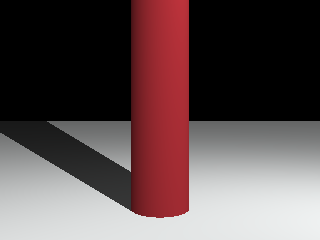

In [14]:
scene = Scene()

mat = [PhongMaterial(color=Vec3(color[i])) for i in ["neutral 8", "red"]]

scene.add(Plane(Vec3(0,0,0), Vec3(0,0,1), mat[0]))

scene.add(CSGCylinder(mat[1]))

camera = PerspectiveCamera(width, height, 45)
camera.setView(Vec3(0.,-10.,3.), Vec3(0.,0.,3.), Vec3(0.,0.,1.))
scene.setCamera(camera)

scene.addLight(PointLight(Vec3(5,-10,10)))
image = engine.render(scene)
image.display()

<div class="alert alert-info">
**Q4** Complétez en ajoutant `CSGBall` et `CSGSlice`.
</div>

In [15]:
class CSGBall(CSGShape):
    def __init__(self, material=PhongMaterial()):
        """La boule de rayon 1 centrée en 0"""
        # TODO : compléter
        
        
        
        
        

# RENDER STATISTICS###############################
TIME FOR RENDERING: 5.169564962387085s
NUMBER OF PRIMARY RAYS: 76800
NUMBER OF SECONDARY RAYS: 0
NUMBER OF SHADOW RAYS: 53440
RAYS/s: 25193.60931676168
##################################################



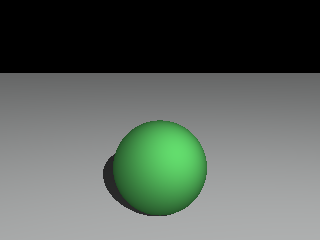

In [16]:
scene = Scene()

mat = [PhongMaterial(color=Vec3(color[i])) for i in ["neutral 8", "green"]]

scene.add(Plane(Vec3(0,0,-1), Vec3(0,0,1), mat[0]))

scene.add(CSGBall(mat[1]))

camera = PerspectiveCamera(width, height, 45)
camera.setView(Vec3(0.,-6.,2.), Vec3(0.,0.,1.), Vec3(0.,0.,1.))
scene.setCamera(camera)

scene.addLight(PointLight(Vec3(2,-10,5)))
image = engine.render(scene)
image.display()

In [17]:
class CSGSlice(CSGShape):
    def __init__(self, material=PhongMaterial()):
        """La tranche d'épaisseur 2 en z centrée en 0"""
        # TODO : compléter
        
        
        
        
        

# RENDER STATISTICS###############################
TIME FOR RENDERING: 4.1874918937683105s
NUMBER OF PRIMARY RAYS: 76800
NUMBER OF SECONDARY RAYS: 0
NUMBER OF SHADOW RAYS: 53440
RAYS/s: 31102.149760294207
##################################################



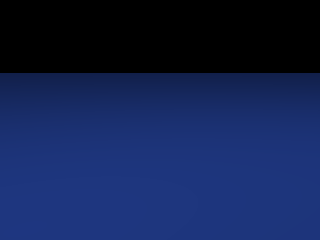

In [18]:
scene = Scene()

mat = [PhongMaterial(color=Vec3(color[i])) for i in ["neutral 8", "blue"]]

scene.add(CSGSlice(mat[1]))

camera = PerspectiveCamera(width, height, 45)
camera.setView(Vec3(0.,-6.,2.), Vec3(0.,0.,1.), Vec3(0.,0.,1.))
scene.setCamera(camera)

scene.addLight(PointLight(Vec3(2,-10,5)))
image = engine.render(scene)
image.display()

### 3.3 Des transformations affines

Dans la représentation en arbre des objets volumiques, on ajoute des transformations affines de l'espace, représentées par des nœuds à un unique fils. L'objet fils subit la transformation décrite par une matrice $M$ pour engendrer l'objet père.

La classe `CSGTransform` applique une transformation affine de l'espace, donnée sous la forme d'une matrice $M$ sur un objet CSG. Pour chacune des 4 méthodes associées à `CSGShape` il s'agit :
* de traduire les coordonnées des points $P$ de l'espace du fils en coordonnées $M\times P$ de l'espace du père;
* de traduire les coordonnées des points $Q$ de l'espace du père en coordonnées $M^{-1}\times Q$ de l'espace du fils.
* ce sont les méthodes de l'objet transformé qui se chargent du gros du travail.

On utilise les coordonnées homogènes (dimension 4) pour représenter les transformations affines de l'espace tridimensionnel.

<div class="alert alert-info">
**Q5** Prenez le temps de comprendre la méthode `hits` puis complétez les 3 méthodes manquantes.
</div>

In [19]:
from pyrt.math.matops import *
from pyrt.math import Ray

def inray(ray, invmat):
    """Transforme un rayon extérieur en un rayon intérieur"""
    instart = invmat*ray.start
    indirection = invmat*(ray.start+ray.direction)-instart
    return Ray(instart, indirection)

class CSGTransform(CSGShape):
    def __init__(self, insider, matrix, name="Affine transform"):
        """l'objet [insider] auquel on a appliqué la transformation affine [matrix]"""
        self.insider=insider
        self.matrix=matrix
        self.invmat=inverse4(matrix)
        self.name=name
    
    def hits(self, ray):
        return self.insider.hits(inray(ray, self.invmat))
    
    # TODO: complétez
    
    
    
    
    

def CSGTranslate(insider,x,y,z): return CSGTransform(insider, createTranslation4(x,y,z), name="Translation(%s,%s,%s)" % (str(x),str(y),str(z)))
def CSGScale(insider,x,y,z): return CSGTransform(insider, createScale4(x,y,z), name="Scale(%s,%s,%s)" % (str(x),str(y),str(z)))
def CSGRotationX(insider,d): return CSGTransform(insider, createRotationX4(deg2rad(d)), name="RotationX(%s)" % str(d))
def CSGRotationY(insider,d): return CSGTransform(insider, createRotationY4(deg2rad(d)), name="RotationY(%s)" % str(d))
def CSGRotationZ(insider,d): return CSGTransform(insider, createRotationZ4(deg2rad(d)), name="RotationZ(%s)" % str(d))

# RENDER STATISTICS###############################
TIME FOR RENDERING: 12.862857103347778s
NUMBER OF PRIMARY RAYS: 76800
NUMBER OF SECONDARY RAYS: 0
NUMBER OF SHADOW RAYS: 22896
RAYS/s: 7750.688606658968
##################################################



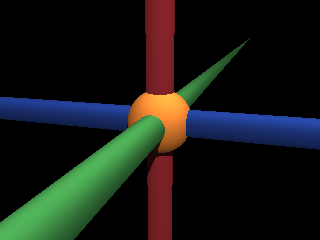

In [20]:
scene = Scene()

mat = [PhongMaterial(color=Vec3(color[i])) for i in ["neutral 8", "green", "red", "blue", "orange"]]

scene.add(CSGScale(CSGRotationX(CSGCylinder(mat[1]),90),0.5,0.5,0.5))
scene.add(CSGScale(CSGCylinder(mat[2]),0.5,0.5,0.5))
scene.add(CSGScale(CSGRotationY(CSGCylinder(mat[3]),90),0.5,0.5,0.5))
scene.add(CSGScale(CSGBall(mat[4]),1.2,1.2,1.2))

camera = PerspectiveCamera(width, height, 45)
camera.setView(Vec3(3.,-10.,3.), Vec3(0.,0.,0.), Vec3(0.,0.,1.))
scene.setCamera(camera)

scene.addLight(PointLight(Vec3(5,-10,10)))
image = engine.render(scene)
image.display()

### 3.4 Des opérations booléennes

Les classes `CSGUnion`, `CSGSubstract`, `CSGIntersection` réalisent des opérations booléennes entre deux objets. Le cœur algorithmique de ces classes réside dans l'écriture de la méthode `hits` qui combine les listes triées d'intervalles retournées par les méthodes `hits` de chacun des objets.

À titre d'exemple, voici le code de `CSGIntersection`. 

In [21]:
def interlist(xs,ys):
    """calcule l'intersection de deux listes triées d'intervalles disjoints"""
    zs=[]
    while xs and ys:
        (a,b)=xs[0]
        (c,d)=ys[0]
        if a < c:
            if b < c:
                xs.pop(0)
            elif b < d:
                zs.append((c,b))
                xs.pop(0)
            else:
                zs.append((c,d))
                ys.pop(0)
        else:
            if d < a:
                ys.pop(0)
            elif d < b:
                zs.append((a,d))
                ys.pop(0)
            else:
                zs.append((a,b))
                xs.pop(0)
    return zs 

class CSGIntersection(CSGShape):
    def __init__(self, left, right):
        self.left=left
        self.right=right
        self.name='Intersection'
    
    def hits(self, ray):
        return interlist(self.left.hits(ray),self.right.hits(ray))
        
    def inside(self, point):
        return self.left.inside(point) and self.right.inside(point)
        
    def onsurface(self, point):
        return self.inside(point) and (self.left.onsurface(point) or self.right.onsurface(point))
        
    def fillhitrecord(self, ray, t, hitrecord):
        point = ray.start+t*ray.direction
        if self.left.onsurface(point):
            self.left.fillhitrecord(ray, t, hitrecord)
        else:
            self.right.fillhitrecord(ray, t, hitrecord)

# RENDER STATISTICS###############################
TIME FOR RENDERING: 14.273316144943237s
NUMBER OF PRIMARY RAYS: 76800
NUMBER OF SECONDARY RAYS: 0
NUMBER OF SHADOW RAYS: 29637
RAYS/s: 7457.061759099941
##################################################



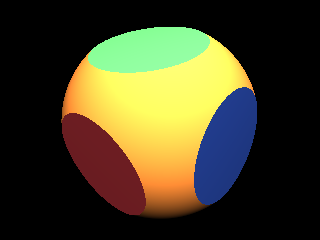

In [22]:
scene = Scene()

mat = [PhongMaterial(color=Vec3(color[i])) for i in ["neutral 8", "green", "red", "blue", "orange"]]

sliceZ=CSGSlice(mat[1])
sliceY=CSGRotationX(CSGSlice(mat[2]),90)
sliceX=CSGRotationY(CSGSlice(mat[3]),90)
objA=CSGIntersection(sliceY,sliceZ)
objB=CSGIntersection(sliceX,objA)
objC=CSGIntersection(CSGScale(CSGBall(mat[4]),1.2,1.2,1.2),objB)
scene.add(CSGRotationX(CSGRotationZ(CSGScale(objC,3,3,3),20),-20))

camera = PerspectiveCamera(width, height, 45)
camera.setView(Vec3(4.,-10.,3.), Vec3(0.,0.,0.), Vec3(0.,0.,1.))
scene.setCamera(camera)

scene.addLight(PointLight(Vec3(5,-10,10)))
image = engine.render(scene)
image.display()

<div class="alert alert-info">
**Q6** Complétez en écrivant le code de `CSGUnion` et `CSGSubstract`.
</div>

In [23]:

class CSGUnion(CSGShape):
    # TODO ALL    

    
    
    

# RENDER STATISTICS###############################
TIME FOR RENDERING: 16.635058164596558s
NUMBER OF PRIMARY RAYS: 76800
NUMBER OF SECONDARY RAYS: 0
NUMBER OF SHADOW RAYS: 48504
RAYS/s: 7532.525510892251
##################################################



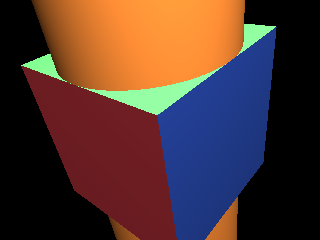

In [24]:
scene = Scene()

mat = [PhongMaterial(color=Vec3(color[i])) for i in ["neutral 8", "green", "red", "blue", "orange"]]

sliceZ=CSGSlice(mat[1])
sliceY=CSGRotationX(CSGSlice(mat[2]),90)
sliceX=CSGRotationY(CSGSlice(mat[3]),90)
objA=CSGIntersection(sliceY,sliceZ)
objB=CSGIntersection(sliceX,objA)
objC=CSGUnion(objB,CSGCylinder(mat[4]))
scene.add(CSGRotationX(CSGRotationZ(CSGScale(objC,3,3,3),20),-20))

camera = PerspectiveCamera(width, height, 45)
camera.setView(Vec3(4.,-10.,3.), Vec3(0.,0.,0.), Vec3(0.,0.,1.))
scene.setCamera(camera)

scene.addLight(PointLight(Vec3(5,-10,10)))
image = engine.render(scene)
image.display()

In [25]:

class CSGSubstract(CSGShape):
    # TODO ALL
    
    
    
    
    
    

# RENDER STATISTICS###############################
TIME FOR RENDERING: 17.325556993484497s
NUMBER OF PRIMARY RAYS: 76800
NUMBER OF SECONDARY RAYS: 0
NUMBER OF SHADOW RAYS: 41935
RAYS/s: 6853.170726035062
##################################################



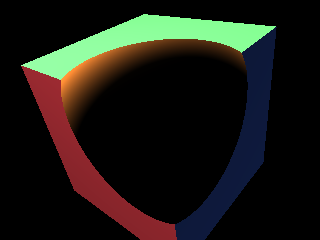

In [26]:
scene = Scene()

mat = [PhongMaterial(color=Vec3(color[i])) for i in ["neutral 8", "green", "red", "blue", "orange"]]

sliceZ=CSGSlice(mat[1])
sliceY=CSGRotationX(CSGSlice(mat[2]),90)
sliceX=CSGRotationY(CSGSlice(mat[3]),90)
objA=CSGIntersection(sliceY,sliceZ)
objB=CSGIntersection(sliceX,objA)
objC=CSGSubstract(objB,CSGTranslate(CSGBall(mat[4]),0.5,-0.5,0.5))
scene.add(CSGRotationX(CSGRotationZ(CSGScale(objC,3,3,3),20),-20))

camera = PerspectiveCamera(width, height, 45)
camera.setView(Vec3(4.,-10.,3.), Vec3(0.,0.,0.), Vec3(0.,0.,1.))
scene.setCamera(camera)

scene.addLight(PointLight(Vec3(0,-10,10)))
image = engine.render(scene)
image.display()

### 3.5 Pour conclure avec CSG

<div class="alert alert-info">
**Q7** Il est temps maintenant de modéliser l'objet représenté sur la figure et de le mettre en scène. À vous de jouer !
</div>

# RENDER STATISTICS###############################
TIME FOR RENDERING: 18.811153173446655s
NUMBER OF PRIMARY RAYS: 76800
NUMBER OF SECONDARY RAYS: 0
NUMBER OF SHADOW RAYS: 58656
RAYS/s: 7200.834459803678
##################################################



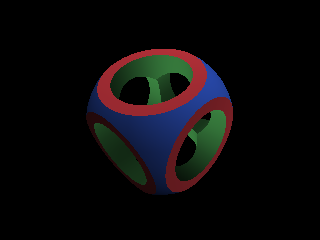

In [27]:
scene = Scene()

mat = [PhongMaterial(color=Vec3(color[i])) for i in ["neutral 8", "green", "red", "blue", "orange"]]







camera = PerspectiveCamera(width, height, 50)
camera.setView(Vec3(3.,-10.,3.), Vec3(0.,0.,0.), Vec3(0.,0.,1.))
scene.setCamera(camera)

scene.addLight(PointLight(Vec3(5,-10,10)))
scene.addLight(PointLight(Vec3(0,0,10)))
scene.addLight(PointLight(Vec3(0,10,0)))
scene.addLight(PointLight(Vec3(10,0,0)))
image = engine.render(scene)
image.display()

<div style="text-align: right; font-size: 80%"><a href="http://www.univ-orleans.fr/lifo/Members/Nicolas.Ollinger/" style="text-decoration: none; color: black">N.O.</a>, le 31 mai 2018</div>